# Link to the lab

https://tinyurl.com/inlplab5

# Setup

We'll use fasttext wiki embeddings in our embedding layer, and pytorch-crf to add a CRF to our BiLSTM.

In [1]:
!pip install fasttext
!pip install pytorch-crf
!pip install datasets

     |████████████████████████████████| 68 kB 2.3 MB/s 
  Using cached pybind11-2.8.0-py2.py3-none-any.whl (207 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3123419 sha256=974b95e4059d3844a82f66a6f7548787d580d1a58a3fc4b29dae1f236640799a
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
     |████████████████████████████████| 270 kB 4.2 MB/s 
     |████████████████████████████████| 243 kB 33.4 MB/s 
     |████████████████████████████████| 125 kB 55.7 MB/s 
     |████████████████████████████████| 1.3 MB 25.0 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 271 kB 45.1 MB/s 
     |████████████████████████████████| 160 kB 52.6 MB/s 


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import io
from math import log
from numpy import array
from numpy import argmax
import torch
import random
from math import log
from numpy import array
from numpy import argmax
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from torchcrf import CRF
from torch.optim.lr_scheduler import ExponentialLR, CyclicLR
from typing import List, Tuple, AnyStr
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from copy import deepcopy
from datasets import load_dataset, load_metric
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import heapq

In [4]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)

enforce_reproducibility()

# Sequence Labeling - recap



Sequence labeling is the task of 
- predicting a class (e.g., POS tag) for each separate token in a textual input
- label tokens as beginning (B), inside (I), or outside (O) 
- predicting which tokens from the input belong to a span, e.g.:
  - which tokens from a document answer a given question (extractive QA)
![](https://rajpurkar.github.io/mlx/qa-and-squad/example-squad.png)
  - which tokens in a news article contain propagandistic techniques
![](https://d3i71xaburhd42.cloudfront.net/237a2b25e1ced676b0ebe8ccaa0cd4b7c5adac6b/5-Figure2-1.png)
  - the spans can be of different types, e.g. type of a Named Entity (NE) -- Person, Location, Organisation
  - ([More datasets for structured prediction](https://huggingface.co/datasets?languages=languages:en&task_categories=task_categories:structure-prediction&sort=downloads))

## Named entity recognition



- identify the **entities** that appear in a document and their types
- e.g., extract from the following sentence all names of the people, locations, and organizations:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<tbody>
 <tr>
    <th class="tg-0pky">Sundar</th>
    <th class="tg-0pky">Pichai</th>
    <th class="tg-0pky">is</th>
    <th class="tg-0pky">the</th>
    <th class="tg-0pky">CEO</th>
    <th class="tg-0pky">of</th>
    <th class="tg-0pky">Alphabet</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">located</th>
    <th class="tg-0pky">in</th>
    <th class="tg-0pky">Mountain</th>
    <th class="tg-0pky">View</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">CA</th>
  </tr>
  <tr>
    <td class="tg-0pky">PER</td>
    <td class="tg-0pky">PER</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">ORG</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">LOC</td>
    <td class="tg-0pky">LOC</td>
    <td class="tg-0pky">LOC</td>
    <td class="tg-0pky">LOC</td>
  </tr>
</tbody>
</table>

- we have labelled all of the tokens associate with their classes as the given type (PER: Person, ORG: Organization, LOC: Location, O: Outside). **Question: What are some issues that could arise as a result of this tagging?

In practice, we will also want to denote which tokens are the beginning of an entity, and which tokens are inside the full entity span, giving the following tagging:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<tbody>
 <tr>
    <th class="tg-0pky">Sundar</th>
    <th class="tg-0pky">Pichai</th>
    <th class="tg-0pky">is</th>
    <th class="tg-0pky">the</th>
    <th class="tg-0pky">CEO</th>
    <th class="tg-0pky">of</th>
    <th class="tg-0pky">Alphabet</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">located</th>
    <th class="tg-0pky">in</th>
    <th class="tg-0pky">Mountain</th>
    <th class="tg-0pky">View</th>
    <th class="tg-0pky">,</th>
    <th class="tg-0pky">CA</th>
  </tr>
  <tr>
    <td class="tg-0pky">B-PER</td>
    <td class="tg-0pky">I-PER</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">B-ORG</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">O</td>
    <td class="tg-0pky">B-LOC</td>
    <td class="tg-0pky">I-LOC</td>
    <td class="tg-0pky">I-LOC</td>
    <td class="tg-0pky">I-LOC</td>
  </tr>
</tbody>
</table>

**Question: What are some other tagging schemes that you think could be good?**

Modeling the dependencies between the predictions can be useful: for example knowing that the previous tag was `B-PER` influences whether or not the current tag will be `I-PER` or `O` or `I-LOC`.

## Download and prepare the data

We'll use a small set of Wikipedia data labelled with people, locations, organizations, and "miscellaneous" entities.

In [5]:
datasets = load_dataset("conll2003")
datasets

Downloading:   0%|          | 0.00/2.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/650k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/163k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/146k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/40e7cb6bcc374f7c349c83acd1e9352a4f09474eb691f64f364ee62eb65d0ca6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [6]:
print(datasets['train'])
print(datasets['train'][0])
print(datasets["train"].features[f"ner_tags"])
print(datasets["train"].features[f"ner_tags"].feature.names)

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
    num_rows: 14041
})
{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}
Sequence(feature=ClassLabel(num_classes=9, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], names_file=None, id=None), length=-1, id=None)
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


We'll create the word embedding space:
- with FastText pretrained embeddings
- using all of the *vocabulary from the train and dev splits*, plus the most frequent tokens from the trained word embeddings. This will reduce the embeddings size!

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2021-10-10 20:58:08--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

p                    88%[================>   ] 576.60M  10.5MB/s    eta 8s     

In [9]:
# Reduce down to our vocabulary and word embeddings
def load_vectors(fname, vocabulary):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    tag_names = datasets["train"].features[f"ner_tags"].feature.names
    final_vocab = tag_names + ['[PAD]', '[UNK]', '[BOS]', '[EOS]']
    final_vectors = [np.random.normal(size=(300,)) for _ in range(len(final_vocab))]
    for j,line in enumerate(fin):
        tokens = line.rstrip().split(' ')
        if tokens[0] in vocabulary or len(final_vocab) < 30000:
          final_vocab.append(tokens[0])
          final_vectors.append(np.array(list(map(float, tokens[1:]))))
    return final_vocab, np.vstack(final_vectors)

class FasttextTokenizer:
    def __init__(self, vocabulary):
        self.vocab = {}
        for j,l in enumerate(vocabulary):
            self.vocab[l.strip()] = j

    def encode(self, text):
        # Text is assumed to be tokenized
        return [self.vocab[t] if t in self.vocab else self.vocab['[UNK]'] for t in text]

In [10]:
vocabulary = (set([t for s in datasets['train'] for t in s['tokens']]) | set([t for s in datasets['validation'] for t in s['tokens']]))
vocabulary, pretrained_embeddings = load_vectors('wiki-news-300d-1M.vec', vocabulary)
print('size of vocabulary: ', len(vocabulary))
tokenizer = FasttextTokenizer(vocabulary)

size of vocabulary:  40630


The main difference in the dataset reading and collation functions is that we now return a sequence of labels instead of a single label as in text classification.

In [11]:
def collate_batch_bilstm(input_data: Tuple) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    input_ids = [tokenizer.encode(i['tokens']) for i in input_data]
    seq_lens = [len(i) for i in input_ids]
    labels = [i['ner_tags'] for i in input_data]

    max_length = max([len(i) for i in input_ids])

    input_ids = [(i + [0] * (max_length - len(i))) for i in input_ids]
    labels = [(i + [0] * (max_length - len(i))) for i in labels] # 0 is the id of the O tag

    assert (all(len(i) == max_length for i in input_ids))
    assert (all(len(i) == max_length for i in labels))
    return torch.tensor(input_ids), torch.tensor(seq_lens), torch.tensor(labels)

In [12]:
dev_dl = DataLoader(datasets['validation'], batch_size=1, shuffle=False, collate_fn=collate_batch_bilstm)
next(iter(dev_dl))

(tensor([[36231,    48,    10, 33561, 30770,  8120, 31121, 21803,    10, 36750,
             15]]), tensor([11]), tensor([[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [13]:
print(datasets['validation'][0])
print(collate_batch_bilstm([datasets['validation'][0]]))

{'id': '0', 'tokens': ['CRICKET', '-', 'LEICESTERSHIRE', 'TAKE', 'OVER', 'AT', 'TOP', 'AFTER', 'INNINGS', 'VICTORY', '.'], 'pos_tags': [22, 8, 22, 22, 15, 22, 22, 22, 22, 21, 7], 'chunk_tags': [11, 0, 11, 12, 13, 11, 12, 12, 12, 12, 0], 'ner_tags': [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]}
(tensor([[36231,    48,    10, 33561, 30770,  8120, 31121, 21803,    10, 36750,
            15]]), tensor([11]), tensor([[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0]]))


# Creating the model

## LSTM model for sequence labeling

You'll notice that the BiLSTM model is mostly the same from the text classification and language modeling labs. The differences are:

- Instead of taking a softmax/cross-entropy loss using the logits from the BiLSTM, we pass the logits to the pytorch-crf CRF module. The output of this model is the **log-likelihood of the entire sequence** (for each sequence in the batch). Since our objective is to minimize the loss, we take the **negative** of the log likelihood as our loss.
- There is now a **decode** function, which passes logits through the CRF to get the most likely tag sequences.

In [ ]:
# Define the model
class BiLSTM(nn.Module):
    """
    Basic BiLSTM-CRF network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTM, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],
                lstm_dim,
                2,
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'ff': nn.Linear(2*lstm_dim, n_classes),
        })
        self.n_classes = n_classes
        self.loss = nn.CrossEntropyLoss()
        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, hidden_states = None, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        if hidden_states:
          lstm_out, hidden = self.model['bilstm'](lstm_in, hidden_states)
        else:
          lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out, hidden_states = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Get logits (b x seq_len x n_classes)
        logits = self.model['ff'](lstm_out)
        outputs = (logits, hidden_states)
        if labels is not None:
            loss = self.loss(logits.reshape(-1, self.n_classes), labels.reshape(-1))
            # log-likelihood from the CRF
            outputs =  outputs + (loss,)

        return outputs

In [ ]:
def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
    scheduler=None,
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  learning_rates = []
  best_f1 = 0.0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      logits, hidden_states, loss = model(input_ids, seq_lens, labels=labels)
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      if scheduler != None:
        scheduler.step()
        learning_rates.append(scheduler.get_last_lr()[0])
        
    # Perform inline evaluation at the end of the epoch
    f1 = evaluate(model, valid_dl)
    print(f'Validation F1: {f1}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    if f1 > best_f1:
      torch.save(model.state_dict(), 'best_model')
      best_f1 = f1

  return losses, learning_rates

In [ ]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  preds_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]
      hidden_states = None

      logits, _, _ = model(input_ids, seq_lens, hidden_states=hidden_states, labels=labels)
      preds_all.extend(torch.argmax(logits, dim=-1).reshape(-1).detach().cpu().numpy())
      labels_all.extend(labels.reshape(-1).detach().cpu().numpy())

    P, R, F1, _ = precision_recall_fscore_support(labels_all, preds_all, average='macro')
    print(confusion_matrix(labels_all, preds_all))
    return F1

In [ ]:
lstm_dim = 128
dropout_prob = 0.1
batch_size = 8
lr = 1e-2
n_epochs = 10

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

# Create the model
model = BiLSTM(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
    lstm_dim=lstm_dim, 
    dropout_prob=dropout_prob, 
    n_classes=len(datasets["train"].features[f"ner_tags"].feature.names)
  ).to(device)

In [ ]:
train_dl = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch_bilstm, num_workers=8)
valid_dl = DataLoader(datasets['validation'], batch_size=len(datasets['validation']), collate_fn=collate_batch_bilstm, num_workers=8)

# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)
scheduler = CyclicLR(optimizer, base_lr=0., max_lr=lr, step_size_up=1, step_size_down=len(train_dl)*n_epochs, cycle_momentum=False)

# Train
losses, learning_rates = train(model, train_dl, valid_dl, optimizer, n_epochs, device, scheduler)
model.load_state_dict(torch.load('best_model'))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1756 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345586     10      5     16      2     10      1     12      5]
 [    54   1756      7      4      0     18      0      3      0]
 [    33     17   1253      1      1      1      1      0      0]
 [    89     49      1   1118      8     63      1     12      0]
 [   144      2      4     32    512     22     21      1     13]
 [    35     10      0     33      0   1745      0     14      0]
 [    16      0      3      0     11      9    217      0      1]
 [   108     12      0     31      1     12      0    749      9]
 [    86      1      4      2     17      6      7     10    213]]
Validation F1: 0.8848369721732365, train loss: 0.14238010607147517


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345502     16      5     41     18     13      3     32     17]
 [    30   1754      5     14      0     27      1     11      0]
 [    29      9   1260      2      2      0      2      1      2]
 [    41     12      1   1174     23     52      0     37      1]
 [    39      0      3      5    646      7     15      3     33]
 [    22      5      1     34      2   1747      2     23      1]
 [     7      0      0      0     14      3    224      0      9]
 [    55     10      0     26      0     14      0    808      9]
 [    35      1      4      1     11      2      9     10    273]]
Validation F1: 0.9098035047089829, train loss: 0.026613018034191898


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345542     17      6     16     16     11      1     25     13]
 [    38   1760      3     16      2     20      0      3      0]
 [    25     13   1250      2     10      0      4      0      3]
 [    72     32      0   1177     12     25      0     22      1]
 [    40      0      2      9    659     13      9      1     18]
 [    32     13      1     31      2   1735      3     20      0]
 [     6      0      1      0      7      3    234      0      6]
 [    67     10      0     27      3     12      1    797      5]
 [    37      1      5      1     36      1     12     11    242]]
Validation F1: 0.9109591093293733, train loss: 0.016845881305080742


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345489     25      2     39     20     10      1     35     26]
 [    27   1770      6     17      1     15      0      6      0]
 [    21     10   1264      1      6      0      2      0      3]
 [    26     28      1   1222     12     23      0     27      2]
 [    51      1      3      8    645      8     12      2     21]
 [    16     12      1     60      2   1723      3     19      1]
 [    10      0      0      0      9      4    223      0     11]
 [    42      8      0     38      4      5      0    817      8]
 [    26      0      4      0     18      1      5     13    279]]
Validation F1: 0.9149483036240542, train loss: 0.011236337263726207


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345463     19      4     53     41     10      1     33     23]
 [    24   1763      6     19      5     18      0      7      0]
 [    14     10   1264      1     11      0      2      0      5]
 [    27     11      1   1224     21     29      0     26      2]
 [    23      0      3     10    677      5     11      1     21]
 [    17      4      1     40      4   1748      2     20      1]
 [     6      0      0      0     11      4    225      0     11]
 [    45     10      0     30      2      9      0    812     14]
 [    24      1      4      2     16      1      2     13    283]]
Validation F1: 0.9178712802210208, train loss: 0.007986236298430933


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345493     25      5     24     29     21      3     31     16]
 [    31   1764      5     19      1     18      0      4      0]
 [    21     11   1258      3      8      0      4      0      2]
 [    36     16      1   1202     15     38      0     32      1]
 [    28      0      3      8    662      4     23      3     20]
 [    16      6      0     18      4   1776      5     11      1]
 [     6      0      0      1      5      0    234      0     11]
 [    41      8      0     20      1     12      0    837      3]
 [    24      0      4      2     13      0      9     18    276]]
Validation F1: 0.9206179841333105, train loss: 0.005072808599908971


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345523     15      4     25     22     12      2     28     16]
 [    33   1766      4     17      1     15      0      6      0]
 [    17     12   1269      2      4      0      0      0      3]
 [    35     20      1   1228     18     19      0     20      0]
 [    33      0      4     10    666      5      8      2     23]
 [    19      6      0     39      4   1747      2     18      2]
 [     7      0      0      0     14      2    224      0     10]
 [    57     10      0     27      2      7      0    808     11]
 [    32      1      5      0     16      1      1     15    275]]
Validation F1: 0.9219900839314558, train loss: 0.003184993840444139


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345480     30      5     45     16     16      3     36     16]
 [    16   1792      6     12      1     12      0      3      0]
 [    18     11   1274      1      1      0      0      1      1]
 [    24     37      1   1221     17     26      0     12      3]
 [    31      1     10     12    658      6     10      3     20]
 [     8     11      0     37      3   1761      4     12      1]
 [     7      0      0      0     11      0    230      0      9]
 [    43     17      0     31      1      8      0    811     11]
 [    26      2      6      0     14      1      1     10    286]]
Validation F1: 0.9249317964734155, train loss: 0.001726480887982523


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345509     20      4     38     13     15      3     31     14]
 [    22   1773      5     19      1     18      0      4      0]
 [    18     10   1270      1      6      0      1      0      1]
 [    33     20      1   1227     15     25      0     17      3]
 [    26      0      5     13    661      5     14      3     24]
 [     9      5      0     32      3   1768      4     15      1]
 [     6      0      0      0     10      2    229      0     10]
 [    48     12      0     30      1      7      0    820      4]
 [    28      0      5      0     13      1      5     14    280]]
Validation F1: 0.9242557873187951, train loss: 0.0011560202627814437


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[345514     19      4     32     14     15      3     30     16]
 [    23   1779      5     12      1     18      0      4      0]
 [    16     11   1271      1      6      0      1      0      1]
 [    31     27      1   1221     16     25      0     17      3]
 [    27      0      4     12    664      7     11      3     23]
 [     9      7      0     29      3   1769      4     15      1]
 [     6      0      0      0     10      2    229      0     10]
 [    52     14      0     26      0      7      0    817      6]
 [    26      1      5      2     12      1      4     13    282]]
Validation F1: 0.9255204487812391, train loss: 0.0007202247060553592


<All keys matched successfully>

In [ ]:
test_dl = DataLoader(datasets['test'], batch_size=len(datasets['test']), collate_fn=collate_batch_bilstm, num_workers=8)

evaluate(model, test_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[419540    105     16    137     70     44     19     84     45]
 [   106   1408     27     45     10     15      1      4      1]
 [    56     16   1064      1     16      0      2      1      0]
 [   117     54      4   1336     32     81      0     36      1]
 [    56      2     15     18    682      5     38      6     13]
 [    65     11      0     54      2   1495      2     38      1]
 [    30      1      5      0     13      5    203      0      0]
 [    69     20      0     36      3     17      0    548      9]
 [    37      0      6      4     12      1      2     10    144]]


0.8369667863680722

# Conditional Random Field (CRF) 

![](https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcTffl57kMgiYxRXlLp26zdz8yfkaxjJR_EvZg&usqp=CAU)

- learn from and perform inference on data whose predictions depend on each other
- a type of graphical model 
- **nodes** are the individual observations you wish to make predictions on 
- **edges** are dependencies between the nodes
- the prediction you make for one token can change your belief about the other tokens
  - after determiners (DT), adjectives and nouns are much more likely than verbs
- unfortunately, trying to model the dependencies between each node in an arbitrarily sized graph is combinatorial and thus intractable, so we have to make some simplifying assumptions.

Assumptions for a **linear chain CRF**:
- assume that your data is structured as a sequence
- assume that your prediction at time $t$ is only dependent on your prediction at time $t - 1$
- you make predictions by modeling two things:
  - the **probability of a label given your input** ($p(y_{t}|X)$)
  - the **probability of a label given the previous label** ($p(y_t|y_{t-1})$).

In the **BiLSTM-CRF**
- input probabilities $p(y_t|X)$ are modeled using the BiLSTM
- the probabilities $p(y_t|y_{t-1})$ are modeled using a transition matrix $V$ of size $n \times n$ where $n$ is the number of tags (i.e., one transition probability for each possible transition). 
- in practice - add a CRF on top of your BiLSTM output logits instead of using a softmax and cross-entropy on the BiLSTM logits.

![](https://www.gabormelli.com/RKB/images/thumb/1/1e/N16-1030_fig1.png/400px-N16-1030_fig1.png)
[Source](https://www.aclweb.org/anthology/N16-1030.pdf)

The model is then trained by maximizing the log-likelihood (i.e. minimizing the negative log-likelihood) of the entire sequence. For more in depth explanation of how this is performed, see the lectures from Hugo Larochelle [here](https://www.youtube.com/watch?v=PGBlyKtfB74&ab_channel=HugoLarochelle).


Only a few lines of code to add a CRF using this third party library: [pytorch-crf](https://pytorch-crf.readthedocs.io/en/stable/). For a more advanced implementation, check [AllenNLP CRF module](https://github.com/allenai/allennlp/blob/master/allennlp/modules/conditional_random_field.py)


In [ ]:
# Define the model
class BiLSTM_CRF(nn.Module):
    """
    Basic BiLSTM-CRF network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(BiLSTM_CRF, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer BiLSTM, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'bilstm': nn.LSTM(
                pretrained_embeddings.shape[1],
                lstm_dim,
                2,
                batch_first=True,
                dropout=dropout_prob,
                bidirectional=True),
            'ff': nn.Linear(2*lstm_dim, n_classes),
            'CRF': CRF(n_classes, batch_first=True)
        })
        self.n_classes = n_classes

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['bilstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n,p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens, labels = None):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](inputs)

        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens.cpu(),
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        lstm_out, hidden = self.model['bilstm'](lstm_in)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out,_ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Get emissions (b x seq_len x n_classes)
        emissions = self.model['ff'](lstm_out)
        outputs = (emissions,)
        if labels is not None:
            mask = (inputs != 0)
            # log-likelihood from the CRF
            log_likelihood = self.model['CRF'](emissions, labels, mask=mask, reduction='token_mean')
            outputs = (-log_likelihood,) + outputs

        return outputs

    def decode(self, emissions, mask):
      """
      Given a set of emissions and a mask, decode the sequence
      """
      return self.model['CRF'].decode(emissions, mask=mask)

## Traning the model

The evaluation function is also slightly different -- we evaluate perfomance based on the decoded sequence from the CRF as opposed to the output of the BiLSTM. We use macro-F1 score for this.

In [ ]:
def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
    scheduler=None,
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  learning_rates = []
  best_f1 = 0.0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      # Pass the inputs through the model, get the current loss and logits
      loss, logits = model(input_ids, seq_lens, labels=labels)
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      if scheduler != None:
        scheduler.step()
        learning_rates.append(scheduler.get_last_lr()[0])
        
    #gc.collect()

    # Perform inline evaluation at the end of the epoch
    f1 = evaluate(model, valid_dl)
    print(f'Validation F1: {f1}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    if f1 > best_f1:
      torch.save(model.state_dict(), 'best_model')
      best_f1 = f1
        #gc.collect()

  return losses, learning_rates

In [ ]:
def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []
  tags_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      seq_lens = batch[1]
      labels = batch[2]

      logits = model(input_ids, seq_lens, labels=labels)[-1]
      mask = (input_ids != 0)
      labels_all.extend([l for seq,samp in zip(list(labels.detach().cpu().numpy()), input_ids) for l,i in zip(seq,samp) if i != 0])
      logits_all.extend(list(logits.detach().cpu().numpy()))
      
      tags = model.decode(logits, mask)
      tags_all.extend([t for seq in tags for t in seq])

    P, R, F1, _ = precision_recall_fscore_support(labels_all, tags_all, average='macro')
    print(confusion_matrix(labels_all, tags_all))
    return F1

In [ ]:
lstm_dim = 128
dropout_prob = 0.1
batch_size = 8
lr = 1e-2
n_epochs = 10

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

# Create the model
model = BiLSTM_CRF(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
    lstm_dim=lstm_dim, 
    dropout_prob=dropout_prob, 
    n_classes=len(datasets["train"].features[f"ner_tags"].feature.names)
  ).to(device)

In [ ]:
train_dl = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch_bilstm, num_workers=8)
valid_dl = DataLoader(datasets['validation'], batch_size=len(datasets['validation']), collate_fn=collate_batch_bilstm, num_workers=8)

# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)
scheduler = CyclicLR(optimizer, base_lr=0., max_lr=lr, step_size_up=1, step_size_down=len(train_dl)*n_epochs, cycle_momentum=False)

# Train
losses, learning_rates = train(model, train_dl, valid_dl, optimizer, n_epochs, device, scheduler)
model.load_state_dict(torch.load('best_model'))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1756 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[42669     6    17    20     3    12     2    22     8]
 [   67  1730     1    14     0    28     1     1     0]
 [   23    21  1249     1     7     0     6     0     0]
 [   82    29     0  1150    10    53     0    17     0]
 [  139     3     7    22   487    20    36     8    29]
 [   40    11     1    33     1  1739     3     9     0]
 [   15     0     2     2     8     5   224     0     1]
 [   88    14     0    49     1    24     0   741     5]
 [   71     1     7     1    21     7    13    16   209]]
Validation F1: 0.8716864222055535, train loss: 0.10189982362569434


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[42599    22    15    48    36     8     3    13    15]
 [   41  1750     5    21     4    17     0     3     1]
 [   17    15  1249     1    17     0     3     0     5]
 [   52    22     1  1190    27    37     0    12     0]
 [   55     1     1    14   647     3    11     1    18]
 [   25     7     1    51    10  1731     2    10     0]
 [    7     0     0     0    29     0   220     0     1]
 [   61    13     0    37     6    12     1   784     8]
 [   32     0     8     0    31     1     9    11   254]]
Validation F1: 0.9022828218165821, train loss: 0.04133661514201062


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[42609    15     6    33    39    10     2    16    29]
 [   26  1770     5    19     2    18     0     2     0]
 [   13    10  1272     0     8     0     3     0     1]
 [   44    22     1  1194    22    36     0    22     0]
 [   46     3     6    10   630     2    19     2    33]
 [   20     8     1    46     8  1739     3    10     2]
 [    5     0     0     0    18     0   233     0     1]
 [   62    14     0    37     1    16     0   782    10]
 [   25     1     6     1    23     2     4     8   276]]
Validation F1: 0.9094217461798593, train loss: 0.02876223595053582


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[42605    36     3    42    25    10     1    21    16]
 [   33  1754     8    14     2    27     0     4     0]
 [   22    14  1261     1     5     0     2     1     1]
 [   35    27     1  1207    17    31     0    22     1]
 [   40     2     6    17   649     6    11     3    17]
 [   17    14     0    43     3  1744     4    12     0]
 [    8     0     4     0    18     1   221     0     5]
 [   60    14     1    34     4     9     0   794     6]
 [   41     1     5     1    27     2     6    11   252]]
Validation F1: 0.9082272243883529, train loss: 0.01990315340402345


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[42585    21     6    44    53    15     3    23     9]
 [   30  1762     5    10     2    26     1     5     1]
 [   12     9  1273     0     7     1     4     0     1]
 [   36    31     1  1195    25    32     1    20     0]
 [   25     0     7    11   678     3    11     0    16]
 [   21     6     0    27     6  1761     2    13     1]
 [    5     0     0     0    17     1   232     0     2]
 [   53    10     0    34     6    12     0   797    10]
 [   23     1     8     1    20     2     1    15   275]]
Validation F1: 0.9193348830695547, train loss: 0.014067151251153409


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[42605    13     2    43    46    15     2    27     6]
 [   27  1770     2    15     2    21     0     4     1]
 [   31     7  1254     4     7     0     3     0     1]
 [   36    26     0  1222    17    29     0    11     0]
 [   33     2     1    11   672     6    12     2    12]
 [   19     8     0    34     3  1760     4     9     0]
 [    8     0     1     2     7     5   230     1     3]
 [   52     9     0    36     2    11     1   805     6]
 [   34     1     4     1    20     2     6    15   263]]
Validation F1: 0.9205293981493333, train loss: 0.008304751937324493


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[42592    31     3    52    33    21     2    16     9]
 [   17  1782     5    15     2    16     0     5     0]
 [   16    10  1268     0     5     1     6     0     1]
 [   31    19     2  1242    16    22     0     9     0]
 [   28     2     4     9   681     3    12     3     9]
 [   17     5     0    37     3  1762     2    11     0]
 [    7     0     0     1     8     1   235     0     5]
 [   58    13     0    37     3    13     1   794     3]
 [   36     0     5     2    19     3     4    19   258]]
Validation F1: 0.9236264820817826, train loss: 0.005777613141861439


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[42631    15     4    41    21    19     3    17     8]
 [   28  1776     3    10     2    18     0     5     0]
 [   16     9  1271     0     3     0     3     0     5]
 [   30    28     1  1220    14    24     0    24     0]
 [   33     0     7    10   654     4     9     3    31]
 [   14     7     0    38     2  1759     4    13     0]
 [    6     0     2     2     7     1   230     0     9]
 [   63    11     0    26     5    10     0   803     4]
 [   36     1     6     2    13     2     3    18   265]]
Validation F1: 0.9195700595162766, train loss: 0.0034720113454166086


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[42628    20     3    33    19    19     2    25    10]
 [   23  1784     3    11     1    15     0     5     0]
 [   21    12  1266     0     4     0     2     0     2]
 [   35    32     1  1207    16    27     0    23     0]
 [   36     1     6    11   648     4    10     4    31]
 [   12     7     0    37     2  1762     4    13     0]
 [    7     0     2     2    11     1   225     0     9]
 [   56    13     0    29     2     9     0   810     3]
 [   34     1     5     2    13     2     4    18   267]]
Validation F1: 0.9178994449449891, train loss: 0.0020337631033050534


  0%|          | 0/1756 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[42646    19     4    32    12    16     2    19     9]
 [   24  1784     4     9     1    16     0     4     0]
 [   23    12  1267     0     2     0     2     0     1]
 [   34    30     1  1210    16    26     0    24     0]
 [   37     1     5    11   651     6    10     3    27]
 [    9     8     0    34     2  1767     4    13     0]
 [    7     0     5     2     7     0   231     0     5]
 [   54    14     0    30     2    10     0   809     3]
 [   33     1     6     2    13     2     4    18   267]]
Validation F1: 0.9225438787962853, train loss: 0.0014855093627089394


<All keys matched successfully>

In [ ]:
test_dl = DataLoader(datasets['test'], batch_size=len(datasets['test']), collate_fn=collate_batch_bilstm, num_workers=8)

evaluate(model, test_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

[[37713   141    26   197   106    47    13    43    37]
 [   96  1423    27    52     9     6     2     2     0]
 [   71    12  1043     1    28     0     0     0     1]
 [  106    51     1  1381    28    78     0    15     1]
 [   49     1    14    16   706     5    32     3     9]
 [   83    17     2    67    12  1457     1    29     0]
 [   27     1     3     1    22     5   196     0     2]
 [   86    19     1    42     7    13     0   527     7]
 [   39     2     4     2    17     2     4     8   138]]


0.8335379631456007

In [ ]:
model.eval()
examples = [0, 2]
for ex in examples:
  samples = [b.to(device) for b in next(iter(test_dl))]

  # Get the emissions. These are basically p(y|x) for each token x,
  # which will be input to the CRF a decoded with the help of p(y_t|y_{t-1})
  (emissions,) = model(samples[0], samples[1])
  mask = (samples[0] != 0)

  tags = model.decode(emissions, mask)

  print([(tok, datasets["train"].features[f"ner_tags"].feature.names[tag], datasets["train"].features[f"ner_tags"].feature.names[gold_tag]) 
    for tok,tag, gold_tag in zip(datasets['test'][ex]['tokens'], tags[ex], datasets['test'][ex]['ner_tags'])])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[('SOCCER', 'O', 'O'), ('-', 'O', 'O'), ('JAPAN', 'B-LOC', 'B-LOC'), ('GET', 'O', 'O'), ('LUCKY', 'B-ORG', 'O'), ('WIN', 'O', 'O'), (',', 'O', 'O'), ('CHINA', 'B-LOC', 'B-PER'), ('IN', 'O', 'O'), ('SURPRISE', 'O', 'O'), ('DEFEAT', 'O', 'O'), ('.', 'O', 'O')]
[('AL-AIN', 'B-LOC', 'B-LOC'), (',', 'O', 'O'), ('United', 'B-LOC', 'B-LOC'), ('Arab', 'I-LOC', 'I-LOC'), ('Emirates', 'I-LOC', 'I-LOC'), ('1996-12-06', 'O', 'O')]


# Beam Search

![](https://miro.medium.com/max/700/1*tEjhWqUgjX37VnT7gJN-4g.png) [(source)](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24)


In [ ]:
# source https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/

def beam_search_decoder(data, k):
  sequences = [[list(), 0.0]]
	# walk over each step in sequence
	for row in data:
		all_candidates = list()
		# expand each current candidate
		for i in range(len(sequences)):
			seq, score = sequences[i]
			for j in range(len(row)):
				candidate = [seq + [j], score - log(row[j])]
				all_candidates.append(candidate)
		# order all candidates by score
		ordered = sorted(all_candidates, key=lambda tup:tup[1])
		# select k best
		sequences = ordered[:k]
	return sequences
 
# define a sequence of 10 words over a vocab of 5 words
data = [[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1],
		[0.1, 0.2, 0.3, 0.4, 0.5],
		[0.5, 0.4, 0.3, 0.2, 0.1]]
data = array(data)
# decode sequence
result = beam_search_decoder(data, 3)
# print result
for seq in result:
	print(seq)

- **Question: Can you find what is the problem with the above?**


- In the above, when generating text, the probability distribution for the next step does not depend on the previous step's choice.
- Beam search is usually employed with encoder-decoder architectures:
![](https://miro.medium.com/max/700/1*GkG_5wg57IpkU8F84nJubQ.png)
- At each step, the decoder receives as input the prediction of the previous step and the hidden state of the previous step.
- During training : at each step provide either the prediction at the previous step with highest probability or the gold label for the next step (teacher forcing).
- During testing: build a beam of top-k generated sequences and re-run the decoder with each of them.

Resources:
- Implementing an encoder-decoder model [example 1](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), [example 2](https://bastings.github.io/annotated_encoder_decoder/)
- Implementing beam search [example](https://github.com/budzianowski/PyTorch-Beam-Search-Decoding/blob/master/decode_beam.py)


In [59]:
class EncoderRNN(nn.Module):
    """
    RNN Encoder model.
    """
    def __init__(self, 
            pretrained_embeddings: torch.tensor, 
            lstm_dim: int,
            dropout_prob: float = 0.1):
        """
        Initializer for EncoderRNN network
        :param pretrained_embeddings: A tensor containing the pretrained embeddings
        :param lstm_dim: The dimensionality of the LSTM network
        :param dropout_prob: Dropout probability
        """
        # First thing is to call the superclass initializer
        super(EncoderRNN, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, and an LSTM layer.
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'lstm': nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, 2, batch_first=True, bidirectional=True),
        })
        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['lstm'].named_parameters())
        for n, p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, inputs, input_lens):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :return: (lstm output state, lstm hidden state) 
        """
        embeds = self.model['embeddings'](inputs)
        lstm_in = nn.utils.rnn.pack_padded_sequence(
                    embeds,
                    input_lens.cpu(),
                    batch_first=True,
                    enforce_sorted=False
                )
        lstm_out, hidden_states = self.model['lstm'](lstm_in)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        return lstm_out, hidden_states


class DecoderRNN(nn.Module):
    """
    RNN Decoder model.
    """
    def __init__(self, pretrained_embeddings: torch.tensor, 
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2):
        """
        Initializer for DecoderRNN network
        :param pretrained_embeddings: A tensor containing the pretrained embeddings
        :param lstm_dim: The dimensionality of the LSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: Number of prediction classes
        """
        # First thing is to call the superclass initializer
        super(DecoderRNN, self).__init__()
        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a LSTM layer, and a feed-forward output layer
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'lstm': nn.LSTM(pretrained_embeddings.shape[1], lstm_dim, 2, bidirectional=True, batch_first=True),
            'nn': nn.Linear(lstm_dim*2, n_classes),
        })
        # Initialize the weights of the model
        self._init_weights()      

    def forward(self, inputs, hidden, input_lens):
        """
        Defines how tensors flow through the model
        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param hidden: (b) The hidden state of the previous step
        :param input_lens: (b) The length of each input sequence
        :return: (output predictions, lstm hidden states) the hidden states will be used as input at the next step
        """
        embeds = self.model['embeddings'](inputs)

        lstm_in = nn.utils.rnn.pack_padded_sequence(
                    embeds,
                    input_lens.cpu(),
                    batch_first=True,
                    enforce_sorted=False
                )
        lstm_out, hidden_states = self.model['lstm'](lstm_in, hidden)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        output = self.model['nn'](lstm_out)
        return output, hidden_states

    def _init_weights(self):
        all_params = list(self.model['lstm'].named_parameters()) + list(self.model['nn'].named_parameters())
        for n, p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

# Define the model
class Seq2Seq(nn.Module):
    """
    Basic Seq2Seq network
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.1,
            n_classes: int = 2
    ):
        """
        Initializer for basic Seq2Seq network
        :param pretrained_embeddings: A tensor containing the pretrained embeddings
        :param lstm_dim: The dimensionality of the LSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(Seq2Seq, self).__init__()

        # We'll define the network in a ModuleDict, which consists of an encoder and a decoder
        self.model = nn.ModuleDict({
            'encoder': EncoderRNN(pretrained_embeddings, lstm_dim, dropout_prob),
            'decoder': DecoderRNN(pretrained_embeddings, lstm_dim, dropout_prob, n_classes),
        })
        self.loss = nn.CrossEntropyLoss(weight=torch.FloatTensor([0.5]+[1]*(len(datasets["train"].features[f"ner_tags"].feature.names)-1)).to(device))


    def forward(self, inputs, input_lens, labels=None):
        """
        Defines how tensors flow through the model. 
        For the Seq2Seq model this includes 1) encoding the whole input text, 
        and running *target_length* decoding steps to predict the tag of each token.

        :param inputs: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b) The length of each input sequence
        :param labels: (b) The label of each sample
        :return: (loss, logits) if `labels` is not None, otherwise just (logits,)
        """

        # Get embeddings (b x sl x embedding dim)
        encoder_output, encoder_hidden = self.model['encoder'](inputs, input_lens)
        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor([tokenizer.encode(['[BOS]'])]*inputs.shape[0], device=device)
        target_length = labels.size(1)

        loss = None
        for di in range(target_length):
            decoder_output, decoder_hidden = self.model['decoder'](
                decoder_input, decoder_hidden, torch.tensor([1]*inputs.shape[0]))

            if loss == None:   
              loss = self.loss(decoder_output.squeeze(1), labels[:, di])
            else:
              loss += self.loss(decoder_output.squeeze(1), labels[:, di])
            # Teacher forcing: Feed the target as the next input
            decoder_input = labels[:, di].unsqueeze(-1) 

        return loss / target_length

In [62]:
def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device,
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_f1 = 0.0

  # Iterate through epochs
  for ep in range(n_epochs):

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      labels = batch[2]
      input_lens = batch[1]

      # Pass the inputs through the model, get the current loss and logits
      loss = model(input_ids, labels=labels, input_lens=input_lens)
      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
        
    # Perform inline evaluation at the end of the epoch
    f1 = evaluate(model, valid_dl)
    print(f'Validation F1: {f1}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    if f1 > best_f1:
      torch.save(model.state_dict(), 'best_model')
      best_f1 = f1
  
  return losses

In [63]:
softmax = nn.Softmax(dim=-1)

def decode(model, inputs, input_lens, labels=None, beam_size=2):
    """
    Decoding/predicting the labels for an input text by running beam search.

    :param inputs: (b x sl) The IDs into the vocabulary of the input samples
    :param input_lens: (b) The length of each input sequence
    :param labels: (b) The label of each sample
    :param beam_size: the size of the beam 
    :return: predicted sequence of labels
    """

    assert inputs.shape[0] == 1
    # first, encode the input text
    encoder_output, encoder_hidden = model.model['encoder'](inputs, input_lens)
    decoder_hidden = encoder_hidden

    # the decoder starts generating after the Begining of Sentence (BOS) token
    decoder_input = torch.tensor([tokenizer.encode(['[BOS]',]),], device=device)
    target_length = labels.shape[1]
    
    # we will use heapq to keep top best sequences so far sorted in heap_queue 
    # these will be sorted by the first item in the tuple
    heap_queue = []
    heap_queue.append((torch.tensor(0), tokenizer.encode(['[BOS]']), decoder_input, decoder_hidden))

    # Beam Decoding
    for _ in range(target_length):
        # print("next len")
        new_items = []
        # for each item on the beam
        for j in range(len(heap_queue)): 
            # 1. remove from heap
            score, tokens, decoder_input, decoder_hidden = heapq.heappop(heap_queue)
            # 2. decode one more step
            decoder_output, decoder_hidden = model.model['decoder'](
                decoder_input, decoder_hidden, torch.tensor([1]))
            decoder_output = softmax(decoder_output)
            # 3. get top-k predictions
            best_idx = torch.argsort(decoder_output[0], descending=True)[0]
            # print(decoder_output)
            # print(best_idx)
            for i in range(beam_size):
                decoder_input = torch.tensor([[best_idx[i]]], device=device)
                
                new_items.append((score + decoder_output[0,0, best_idx[i]],
                                  tokens + [best_idx[i].item()], 
                                  decoder_input, 
                                  decoder_hidden))
        # add new sequences to the heap
        for item in new_items:
          # print(item)
          heapq.heappush(heap_queue, item)
        # remove sequences with lowest score (items are sorted in descending order)
        while len(heap_queue) > beam_size:
          heapq.heappop(heap_queue)
          
    final_sequence = heapq.nlargest(1, heap_queue)[0]
    assert labels.shape[1] == len(final_sequence[1][1:])
    return final_sequence

In [64]:
def evaluate(model: nn.Module, valid_dl: DataLoader, beam_size:int = 1):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  # VERY IMPORTANT: Put your model in "eval" mode -- this disables things like 
  # layer normalization and dropout
  model.eval()
  labels_all = []
  logits_all = []
  tags_all = []

  # ALSO IMPORTANT: Don't accumulate gradients during this process
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      input_lens = batch[1]
      labels = batch[2]

      best_seq = decode(model, input_ids, input_lens, labels=labels, beam_size=beam_size)
      mask = (input_ids != 0)
      labels_all.extend([l for seq,samp in zip(list(labels.detach().cpu().numpy()), input_ids) for l,i in zip(seq,samp) if i != 0])
      tags_all += best_seq[1][1:]
      # print(best_seq[1][1:], labels)
    P, R, F1, _ = precision_recall_fscore_support(labels_all, tags_all, average='macro')
    print(confusion_matrix(labels_all, tags_all))
    return F1

In [66]:
lstm_dim = 300
dropout_prob = 0.1
batch_size = 64
lr = 1e-3
n_epochs = 20

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

# Create the model
model = Seq2Seq(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
    lstm_dim=lstm_dim, 
    dropout_prob=dropout_prob, 
    n_classes=len(datasets["train"].features[f"ner_tags"].feature.names)
  ).to(device)

In [67]:
train_dl = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch_bilstm, num_workers=8)
valid_dl = DataLoader(datasets['validation'], batch_size=1, collate_fn=collate_batch_bilstm, num_workers=8)

# Create the optimizer
optimizer = Adam(model.parameters(), lr=lr)

# Train
losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device)
model.load_state_dict(torch.load('best_model'))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/220 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[38809    94    91    53   350   196  3158     5     3]
 [  744   609    61     6    39    66   317     0     0]
 [  481    23   426     0    39    23   315     0     0]
 [  587    13     9   507    60    56   104     5     0]
 [  430     2     8    17   177     8   108     0     1]
 [  826     5     1    30    16   730   229     0     0]
 [  132     1     2     0    13     8   101     0     0]
 [  719     3     1    12     2    41    91    52     1]
 [  244     1     1     3     7     2    61     0    27]]
Validation F1: 0.373727924742792, train loss: 0.23305348686196586


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[40862   343   330    60   300   317   356    48   143]
 [  518  1023   209     8    14    40    15     2    13]
 [  435    93   743     1    10     8    11     0     6]
 [  380    39    30   661    91    74    34    26     6]
 [  202    11    33    36   348    15    80     5    21]
 [  523    27    17    33    21  1126    56    21    13]
 [  103     1     5     4    17    21    97     1     8]
 [  492    19     2    16    11   103    22   235    22]
 [  161     4     8     6    22    22    34     4    85]]
Validation F1: 0.5124419692529194, train loss: 0.12469297058203004


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[40939   397   327   186   441   229    84   108    48]
 [  333  1210   211    21    28    26     5     5     3]
 [  282   111   867     2    23    12     5     1     4]
 [  244    48    13   796   137    48     7    43     5]
 [  132     8    24    20   496     7    18     8    38]
 [  340    30     9    69    36  1261    36    51     5]
 [   48     1     6     1    46    18   118     2    17]
 [  322    20     6    49    23    33     9   441    19]
 [  114     2     7    10    48    11    20    17   117]]
Validation F1: 0.6061774429253762, train loss: 0.08781490500339052


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41059   325   203   125   566   289    84    83    25]
 [  323  1304   134    14    33    23     5     3     3]
 [  292    68   893    10    34     3     5     1     1]
 [  180    60    11   872   120    65    11    21     1]
 [  136     7    29    31   502    10    27     2     7]
 [  330    35    11    50    41  1314    45    10     1]
 [   52     0    10     3    38    15   138     0     1]
 [  284    27     5    58    27    44     5   463     9]
 [  121     3     6     8    62     7    20    15   104]]
Validation F1: 0.6365435478182362, train loss: 0.06919786352664233


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41368   291   177   217   202   239    40   116   109]
 [  211  1390   152    24    18    27     4     6    10]
 [  220    70   970     8    22     5     2     3     7]
 [  139    43     9   967    93    47     3    29    11]
 [  118     3    14    39   518     7    15     6    31]
 [  211    13     9    72    11  1467    23    22     9]
 [   29     1     4     2    41    17   149     2    12]
 [  226    16     3    67    16    38     4   527    25]
 [   70     2     5     8    61     4    14    26   156]]
Validation F1: 0.6900983560145298, train loss: 0.057232663602652875


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41529   141   187   120   174   212    60   257    79]
 [  241  1402    80    26    20    39     3    17    14]
 [  192    75   993     4    25     4     4     4     6]
 [  164    26     3   899    92    78    13    57     9]
 [  130     3     9    31   466    14    37     6    55]
 [  202     7     3    35     9  1492    46    37     6]
 [   40     0     1     1    16    18   165     1    15]
 [  240     6     0    41     6    30     3   552    44]
 [   97     2     4     5    30     5    15    20   168]]
Validation F1: 0.6925435751067381, train loss: 0.05146351747045463


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41641   194   121   137   207   181    93    64   121]
 [  183  1463    97    25    26    32     3     5     8]
 [  170    54  1030     9    28     4     2     3     7]
 [  123    29     3   986   110    61     5    14    10]
 [   93     1    10    19   580     3    22     4    19]
 [  165    13     1    46     8  1555    26    13    10]
 [   31     0     5     0    21    14   176     0    10]
 [  202    17     3    61    16    38     2   548    35]
 [   59     2     6     6    60     2    12    19   180]]
Validation F1: 0.7297426265400553, train loss: 0.04172725680030205


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41969   160   124    56   138   119     9    95    89]
 [  200  1515    72     6    11    22     1     8     7]
 [  174    62  1044     2    12     3     2     1     7]
 [  154    38     7   952    72    67     1    44     6]
 [  120     1    10    37   498    13    29     4    39]
 [  175    12     5    27     4  1570    12    25     7]
 [   35     3     5     0    11    12   177     2    12]
 [  194    16     1    31     5    20     0   636    19]
 [   68     1     6     5    23     6     5    30   202]]
Validation F1: 0.765451701378486, train loss: 0.0337931162762371


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41946   125    98    85   114   144    28    91   128]
 [  172  1535    50    23    12    32     4     7     7]
 [  133    73  1060     9    19     2     6     0     5]
 [  103    21     8  1050    44    83     2    20    10]
 [   87     6     7    37   550     5    25     4    30]
 [  108    15     3    42     8  1626    16    11     8]
 [   22     1     1     0    15    14   190     1    13]
 [  145    14     1    54     7    38     2   632    29]
 [   49     1     7     6    35     4    18    14   212]]
Validation F1: 0.7771136819863759, train loss: 0.028977790436792102


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41641   222   156    64   171   111    52   168   174]
 [  139  1521   104    10    15    28     4    10    11]
 [  151    45  1069     4    18     3     8     2     7]
 [   81    53     6   991    87    64     6    45     8]
 [   66     2    25    23   529     7    36     3    60]
 [  122    19     8    41    11  1568    34    24    10]
 [   21     2     3     0    11    11   198     3     8]
 [  133    21     6    35     8    29     1   651    38]
 [   46     0     7     4    29     1    18    16   225]]
Validation F1: 0.7490957093698465, train loss: 0.026413780186240646


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41765   149   114   114   185    69    18   132   213]
 [  153  1519    77    37    10    26     2     6    12]
 [  136    60  1072     4    22     2     4     0     7]
 [   59    25     5  1056    94    42     2    39    19]
 [   55     1     9    18   602     3    11     5    47]
 [   99    11     0    58     9  1606    14    26    14]
 [   17     0     2     1    18     8   194     2    15]
 [  122    11     2    45     7    28     2   660    45]
 [   30     0     5     4    37     1     9    16   244]]
Validation F1: 0.7788986734680036, train loss: 0.02410994344602593


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41778   220   152   105   150   153    32   102    67]
 [  125  1549    94    15     9    31     4    10     5]
 [  122    61  1089     2    16     5     6     0     6]
 [   77    34    12  1043    76    50     3    34    12]
 [   67     2    17    16   588     5    19     6    31]
 [   98    11     4    50    10  1616    26    18     4]
 [   16     1     1     1    18     9   205     0     6]
 [  117    17     0    40     6    26     2   687    27]
 [   49     2     7     3    29     4     9    18   225]]
Validation F1: 0.7894464131238225, train loss: 0.019622133931526068


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41876   252   158   121    87   101    10    99    55]
 [  141  1521   107    31     5    24     2     4     7]
 [  154    59  1062    10    11     6     2     0     3]
 [   83    28     2  1094    57    41     3    30     3]
 [  102     1     7    16   583     6    14     3    19]
 [  110    13     4    76     7  1589    17    19     2]
 [   20     0     1     1    15    14   197     2     7]
 [  125    18     1    40     7    18     1   684    28]
 [   53     1     7     5    25     1     4    12   238]]
Validation F1: 0.8046403483192962, train loss: 0.018928204641931436


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41952   127    99    82   166   109    27   101    96]
 [  156  1566    53    17     5    31     2     5     7]
 [  144    64  1080     3    12     0     1     1     2]
 [   97    35     8   997    72    78     4    40    10]
 [   62     3    10    22   567     4    32     4    47]
 [  101    20     3    35    11  1619    17    26     5]
 [   19     0     6     0    10    13   194     2    13]
 [  137    24     1    28     6    18     1   682    25]
 [   56     1     7     5    18     4     5    24   226]]
Validation F1: 0.787497558974126, train loss: 0.023627036884003742


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41873   185   120    52   117    88    81   108   135]
 [  122  1597    77     3     4    21     3    10     5]
 [  119    46  1115     3     4     6     4     3     7]
 [   87    56     9   993    60    58     7    49    22]
 [   42     1    24    13   523     2    44    10    92]
 [  105    23     2    47     8  1594    23    25    10]
 [   12     1     8     0    16     7   196     2    15]
 [  128    23     0    24     4    26     3   690    24]
 [   42     0     7     4    16     1    10    23   243]]
Validation F1: 0.7722562922730529, train loss: 0.0190263554665514


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41759   121   119   127   280   101    80    99    73]
 [  171  1542    47    31    12    24     3     8     4]
 [  110    62  1095     3    24     3     4     0     6]
 [   92    31     2  1055   103    38     2    15     3]
 [   27     1     7    17   661     2    18     1    17]
 [  123    20     3    89    17  1546    22    15     2]
 [   11     1     5     1    35     8   190     0     6]
 [  193    16     0    50    10    17     7   604    25]
 [   46     1     6     7    42     2    11    13   218]]
Validation F1: 0.7753492698585864, train loss: 0.017633977784267202


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[42076   142   115    89   110    79    13    87    48]
 [  140  1584    55    21     5    28     2     3     4]
 [  134    42  1104     4    11     3     7     0     2]
 [   95    28     3  1074    60    54     1    24     2]
 [   53     1     7    21   625     2    21     5    16]
 [  112    17     3    41     7  1638     7    11     1]
 [   22     0     5     1    14     8   195     2    10]
 [  132    14     0    52     6    24     1   675    18]
 [   45     2     8     5    38     2    14    23   209]]
Validation F1: 0.8138191088516559, train loss: 0.019318972206251186


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[42059   137   120    77   114    86    12    85    69]
 [  159  1589    45    11     5    25     1     7     0]
 [  129    60  1099     3     9     4     2     1     0]
 [   74    37     5  1080    57    49     2    32     5]
 [   64     2    10    12   629     3    11     4    16]
 [  100    15     2    48     9  1631     7    17     8]
 [   17     2     5     2    13     7   203     0     8]
 [  129    10     2    44     4    16     0   693    24]
 [   40     1     6     2    24     7     4    24   238]]
Validation F1: 0.8265346935992475, train loss: 0.014547100761608983


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[41989   153   116   102   163    87    25    63    61]
 [  130  1595    60    18     9    24     1     3     2]
 [  130    53  1103     4    12     2     2     0     1]
 [   72    42     6  1101    74    32     0    12     2]
 [   47     2    12    13   647     0    13     1    16]
 [   89    18     5    53     5  1627    17    17     6]
 [   22     0     8     1    17     8   187     1    13]
 [  126    14     1    54     7    22     2   673    23]
 [   44     1     8     4    37     2     7    18   225]]
Validation F1: 0.812311654460772, train loss: 0.012226003556596962


  0%|          | 0/220 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/3250 [00:00<?, ?it/s]

[[42147   124    67   109   112    62    12    88    38]
 [  151  1608    40    15     3    19     0     3     3]
 [  140    54  1097     7     5     0     0     3     1]
 [   66    42     7  1119    44    38     2    21     2]
 [   56     5     8    19   631     1    15     3    13]
 [   76    26     4    49     6  1648    12    14     2]
 [   16     2     5     0    19     7   205     0     3]
 [   91    18     1    55     5    17     2   713    20]
 [   41     2     7     5    36     3     5    23   224]]
Validation F1: 0.8347921642916494, train loss: 0.009313304909102788


<All keys matched successfully>

**Question: Do you have ideas how to improve the model?**
How about adding attention mechanism for the decoder to attend to the separate hidden states of the separate token steps in the encoder? (see the resources)


In [68]:
test_dl = DataLoader(datasets['test'], batch_size=1, collate_fn=collate_batch_bilstm, num_workers=8)
evaluate(model, test_dl, beam_size=1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluation:   0%|          | 0/3453 [00:00<?, ?it/s]

[[37092   237   111   313   218    97    32   133    90]
 [  188  1254    51    73    19    20     0     9     3]
 [  177    55   868     3    38     4     4     3     4]
 [  133    58     4  1264    77    69     2    53     1]
 [   93     4    12    33   639     7    30     2    15]
 [  140    42     5   107    24  1304    11    32     3]
 [   26     0    10     4    33     9   165     1     9]
 [   94    23     6    57    10    16     1   479    16]
 [   45     3     8     1    23     1     2    11   122]]


0.727843916681434

In [69]:
evaluate(model, test_dl, beam_size=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Evaluation:   0%|          | 0/3453 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[[37128   232   121   311   209    93    32   128    69]
 [  185  1270    49    68    14    18     0    10     3]
 [  163    60   887     4    32     2     1     3     4]
 [  135    64     5  1275    66    70     2    43     1]
 [   86     6    15    30   645     8    30     2    13]
 [  126    41     7   105    26  1314    16    31     2]
 [   28     0    10     4    36     7   167     0     5]
 [   92    26     6    61    10    16     2   476    13]
 [   48     2     8     1    22     1     2    12   120]]


0.7355817928230471

# Learning rate schedules

Motivation: 
- speed up training
- to train a better model

With Pytorch:
- choose a learning rate schedulers form `torch.optim.lr_schedule`
- add a line in your training loop which calls the `step()` function of your scheduler
- this will automatically change your learning rate! 
- **Note**: be aware of when to call `step()`; some schedulers change the learning rate after every epoch, and some change after every training step (batch). The one we will use here changes the learning rate after every training step. We'll define the scheduler in the cell that calls the `train()` function. 

Set up hyperparameters and create the model. Note the high learning rate -- this is partially due to the learning rate scheduler we will use.

In [ ]:
lstm_dim = 128
dropout_prob = 0.1
batch_size = 8
lr = 1e-2
n_epochs = 10

device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")

# Create the model
model = BiLSTM_CRF(
    pretrained_embeddings=torch.FloatTensor(pretrained_embeddings), 
    lstm_dim=lstm_dim, 
    dropout_prob=dropout_prob, 
    n_classes=len(label_map)
  ).to(device)

Above we have used the `CyclicLR` scheduler. The cyclic learning rate schedule in general looks like this:

![](https://ai-how.github.io/img/CLR.png) [Source](https://arxiv.org/pdf/1506.01186.pdf)

We are using it here to linearly decay the learning rate from a starting max learning rate (here 1e-2) down to 0 over the entire course of training (essentially one cycle that starts at the max and ends at 0). 

" Allowing the learning rate to rise and fall is beneficial overall
even though it might temporarily harm the network’s performance"

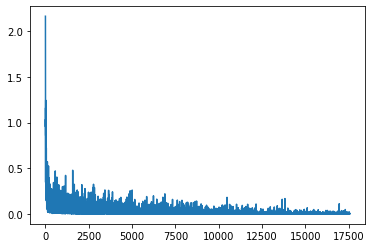

In [ ]:
plt.plot(losses)

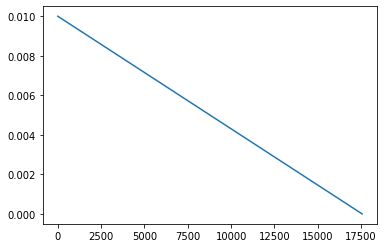

In [ ]:
plt.plot(learning_rates)

# Transformers for sequence labeling

- have to adjust the vocabulary where a word is split into multiple word piesces
- [Tutorial on NER](https://github.com/huggingface/notebooks/blob/master/examples/token_classification.ipynb)
- Some generative transformers now perform the same as token classification transformers [e.g. T5 can extract the span of a tweet that contains a sentiment](https://github.com/enzoampil/t5-intro/blob/master/t5_qa_training_pytorch_span_extraction.ipynb)